# Tutorial


In [55]:
import sklearn
from tsai.basics import *

dsid = 'ILI'
df_raw = get_long_term_forecasting_data(dsid)
df_raw

,date,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,2002-01-01,1.222620,1.166680,582,805,2060,754,176569
1,2002-01-08,1.333440,1.216500,683,872,2267,785,186355
2,2002-01-15,1.319290,1.130570,642,878,2176,831,192469
3,2002-01-22,1.494840,1.252460,728,1045,2599,863,207512
4,2002-01-29,1.471950,1.302370,823,1189,2907,909,223208
...,...,...,...,...,...,...,...,...
961,2020-06-02,0.839059,0.846722,2756,3528,12913,3258,1525058
962,2020-06-09,0.895958,0.908885,3203,3778,13979,3254,1538038
963,2020-06-16,0.910926,0.941625,3478,3796,14389,3177,1528103
964,2020-06-23,0.946945,0.972185,3734,3818,14999,3066,1542813


In [56]:
datetime_col = "date"
freq = '7D'
columns = df_raw.columns[1:]
method = 'ffill'
value = 0

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)), # drop duplicate rows (if any)
    ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)), # ass missing timestamps (if any)
    ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ], 
    verbose=True)
mkdir('data', exist_ok=True, parents=True)
save_object(preproc_pipe, 'data/preproc_pipe.pkl')
preproc_pipe = load_object('data/preproc_pipe.pkl')

df = preproc_pipe.fit_transform(df_raw)
df

data directory already exists.
Pipeline saved as data\preproc_pipe.pkl
Initial memory usage: 60.50 KB  
Final memory usage  : 30.31 KB   (-49.9%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.0s


,date,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,2002-01-01,1.222620,1.166680,582,805,2060,754,176569
1,2002-01-08,1.333440,1.216500,683,872,2267,785,186355
2,2002-01-15,1.319290,1.130570,642,878,2176,831,192469
3,2002-01-22,1.494840,1.252460,728,1045,2599,863,207512
4,2002-01-29,1.471950,1.302370,823,1189,2907,909,223208
...,...,...,...,...,...,...,...,...
961,2020-06-02,0.839059,0.846722,2756,3528,12913,3258,1525058
962,2020-06-09,0.895958,0.908885,3203,3778,13979,3254,1538038
963,2020-06-16,0.910926,0.941625,3478,3796,14389,3177,1528103
964,2020-06-23,0.946945,0.972185,3734,3818,14999,3066,1542813


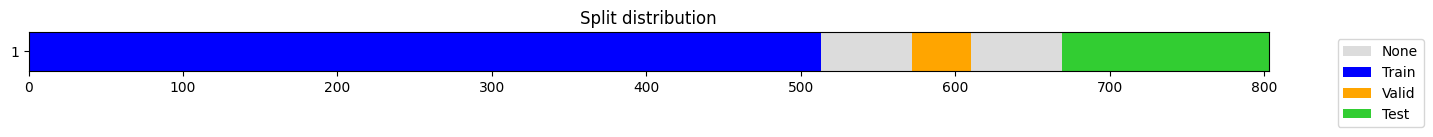

((#513) [0,1,2,3,4,5,6,7,8,9...],
 (#38) [572,573,574,575,576,577,578,579,580,581...],
 (#134) [669,670,671,672,673,674,675,676,677,678...])

In [57]:
fcst_history = 104 # # steps in the past
fcst_horizon = 60  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_long_term_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, dsid=dsid)
splits

In [58]:
columns = df.columns[1:]
train_split = splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ], 
    verbose=True)
save_object(exp_pipe, 'data/exp_pipe.pkl')
exp_pipe = load_object('data/exp_pipe.pkl')

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=train_split)
df_scaled

data directory already exists.
Pipeline saved as data\exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,date,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,2002-01-01,-0.388910,-0.435545,-0.868236,-0.578640,-0.709860,-0.924247,-1.159122
1,2002-01-08,-0.299851,-0.392230,-0.818759,-0.563340,-0.685642,-0.859891,-1.113758
2,2002-01-15,-0.311222,-0.466939,-0.838844,-0.561970,-0.696289,-0.764394,-1.085416
3,2002-01-22,-0.170144,-0.360966,-0.796715,-0.523832,-0.646799,-0.697961,-1.015684
4,2002-01-29,-0.188539,-0.317573,-0.750177,-0.490947,-0.610764,-0.602464,-0.942924
...,...,...,...,...,...,...,...,...
961,2020-06-02,-0.697154,-0.713722,0.196745,0.043204,0.559907,4.274116,5.091879
962,2020-06-09,-0.651428,-0.659677,0.415718,0.100296,0.684625,4.265812,5.152048
963,2020-06-16,-0.639399,-0.631212,0.550432,0.104406,0.732594,4.105958,5.105994
964,2020-06-23,-0.610453,-0.604642,0.675839,0.109430,0.803962,3.875520,5.174183


In [59]:
x_vars = df.columns[1:]
y_vars = df.columns[1:]

In [60]:

X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((803, 7, 104), (803, 7, 60))

In [63]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="LSTMPlus", metrics=[mse, mae], cbs=ShowGraph())
# learn.dls.valid.drop_last = True
learn.summary()

not enough values to plot a chart


LSTMPlus (Input shape: 16 x 7 x 104)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 7 x 104        
Identity                                                       
Identity                                                       
____________________________________________________________________________
                     16 x 104 x 100      
LSTM                                                           
____________________________________________________________________________
                     16 x 104 x 100      
LSTMOutput                                                     
____________________________________________________________________________
                     16 x 100 x 104      
Transpose                                                      
____________________________________________________________________________
                     16 x 10400          
Reshape                                                      

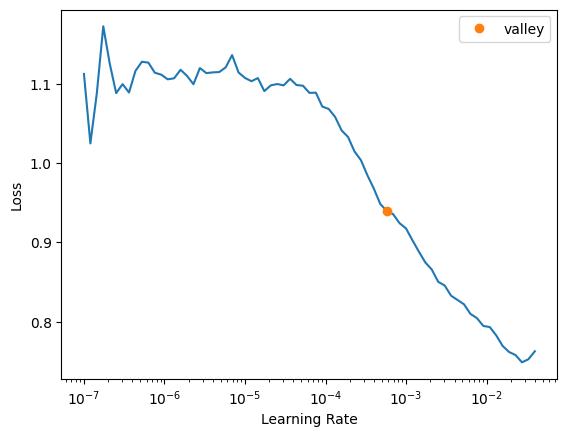

In [64]:
lr_max = learn.lr_find().valley

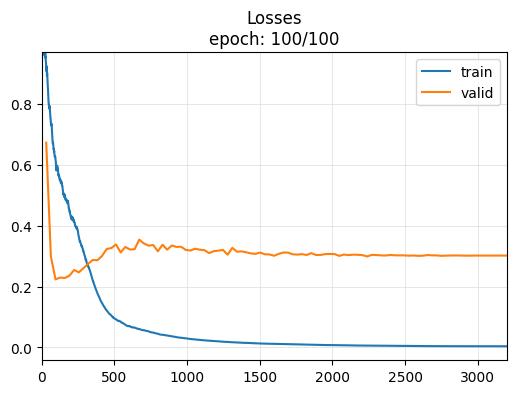

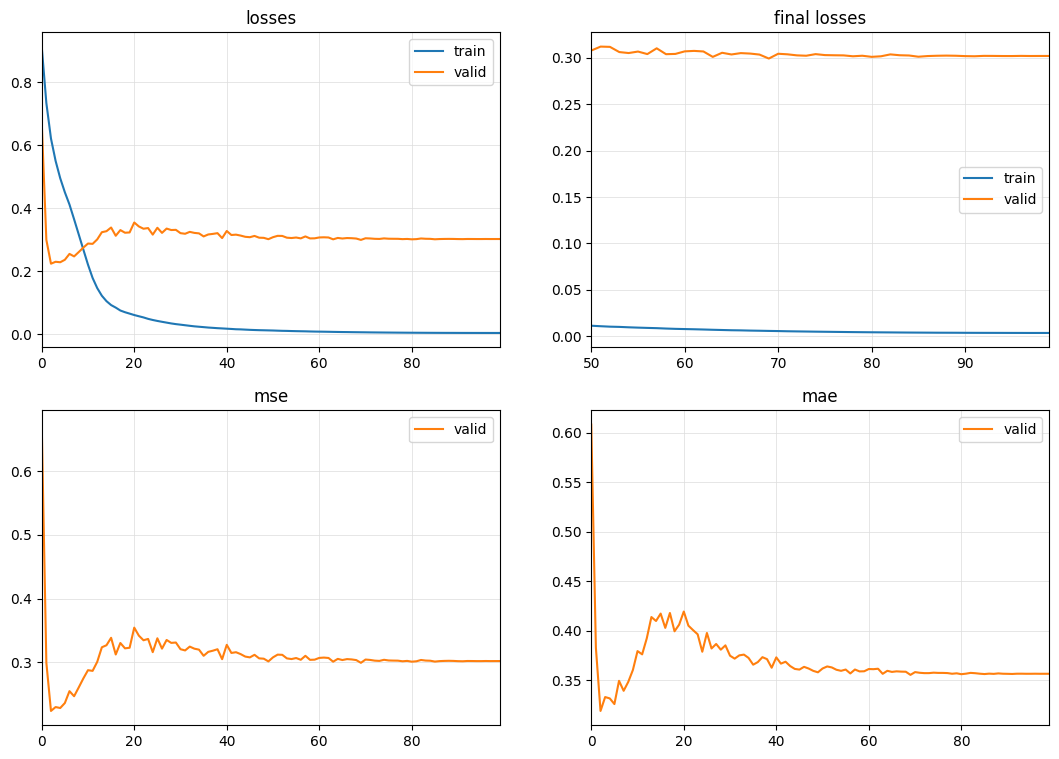

In [65]:
n_epochs = 100
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('temp.pt')

In [66]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/temp.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

y_test_preds.shape: (134, 7, 60)


,mse,mae
test,4.365259,1.433391


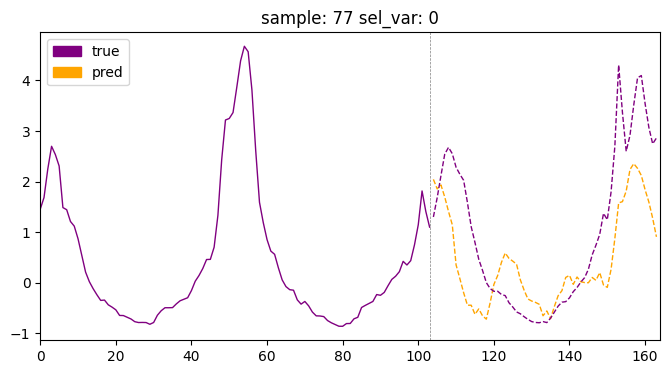

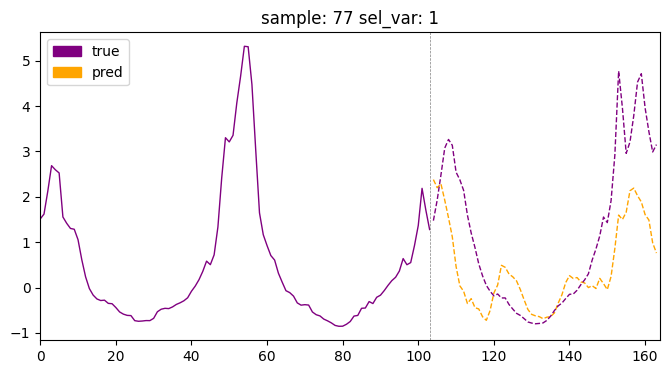

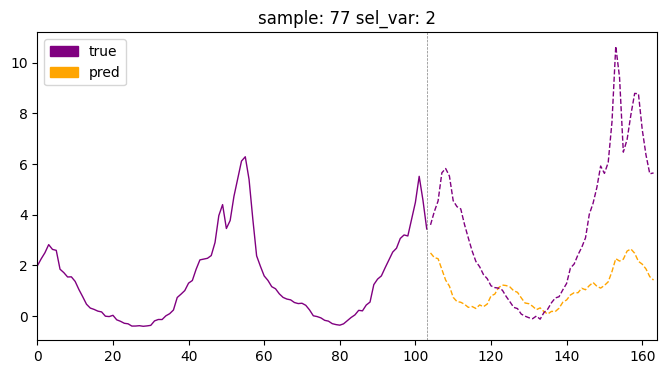

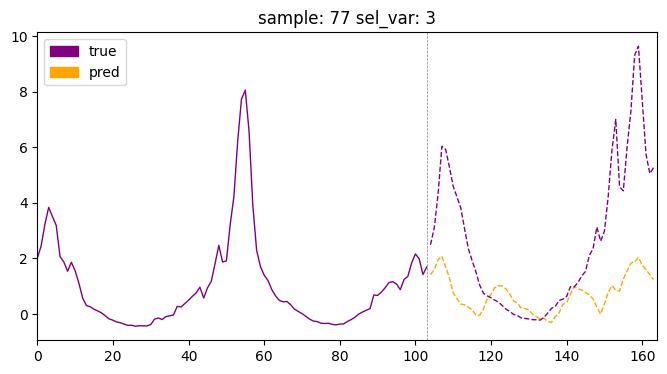

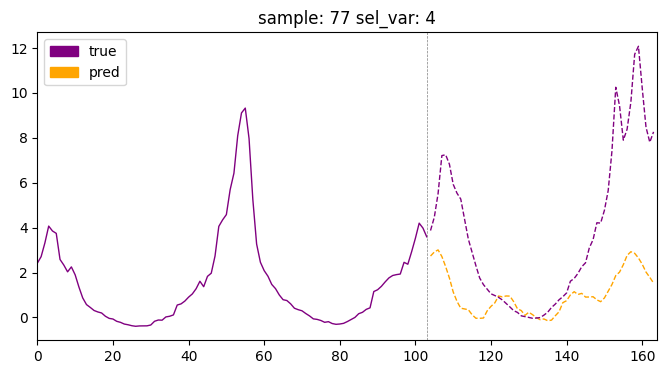

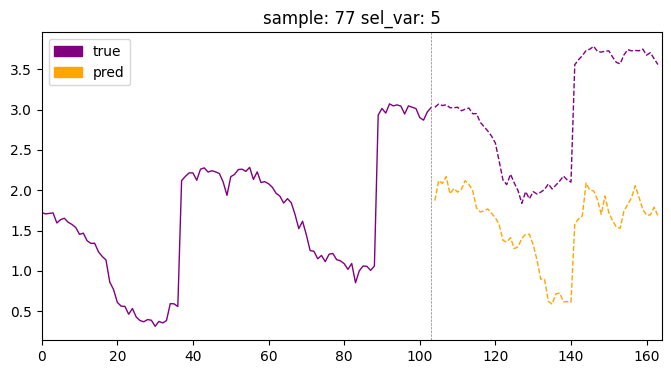

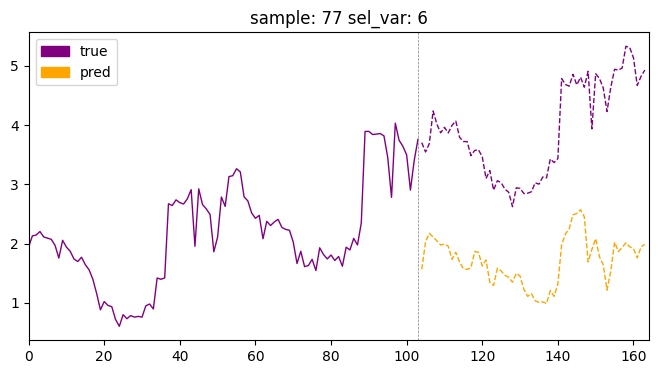

In [67]:
X_test = X[splits[2]]
y_test = y[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)

# Apply for custom data


In [1]:
from sklearn.base import TransformerMixin, BaseEstimator

class DateTimeConverter(TransformerMixin, BaseEstimator):
    def __init__(self, 
                 datetime_col):
        self.datetime_col = datetime_col
    def fit(self, X, y=None, **fit_params):
        X[self.datetime_col] = pd.to_datetime(X[self.datetime_col])
        return self
    def transform(self, X, y=None, **fit_params):
        X[self.datetime_col] = pd.to_datetime(X[self.datetime_col])
        return X

In [2]:
import sklearn
import pandas as pd
from pathlib import Path
from tsai.basics import *

dataPath = Path('data/airline/airline.csv')
folderPath = dataPath.parent
df_raw = pd.read_csv(dataPath)
df_raw

,Month,passengers_in_thousands
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [20]:
datetime_col = "Month"
freq = 'MS'
columns = df_raw.columns[1:]
method = 'ffill'
value = 0

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('datetime_converter', DateTimeConverter(datetime_col=datetime_col)), # convert datetime column to datetime
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)), # drop duplicate rows (if any)
    ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)), # ass missing timestamps (if any)
    ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ], 
    verbose=True)

save_object(preproc_pipe, folderPath /'preproc_pipe.pkl')

data\airline directory already exists.
Pipeline saved as data\airline\preproc_pipe.pkl


In [21]:
preprocessPipePath = Path('data/airline/preproc_pipe.pkl')

preproc_pipe = load_object(preprocessPipePath)
df = preproc_pipe.fit_transform(df_raw)
df

[Pipeline]  (step 1 of 5) Processing datetime_converter, total=   0.0s
Initial memory usage: 2.38 KB   
Final memory usage  : 1.53 KB    (-35.5%)
[Pipeline] .......... (step 2 of 5) Processing shrinker, total=   0.0s
[Pipeline] ... (step 3 of 5) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 4 of 5) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 5 of 5) Processing fill_missing, total=   0.0s


,Month,passengers_in_thousands
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


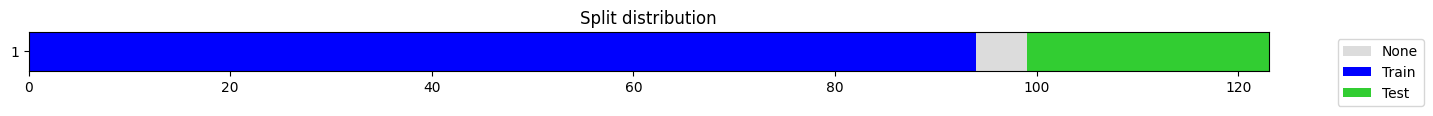

((#94) [0,1,2,3,4,5,6,7,8,9...],
 (#24) [99,100,101,102,103,104,105,106,107,108...])

In [22]:
fcst_history = 16 # # steps in the past
fcst_horizon = 6 # # steps in the future

splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, valid_size=0.2,test_size = 0)
splits

In [23]:
columns = df.columns[1:]
train_split = splits[0]

scalePipePath = Path('data/airline/scale_pipe.pkl')
# pipeline
scale_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ], 
    verbose=True)


save_object(scale_pipe, scalePipePath)
scale_pipe = load_object(scalePipePath)

df = scale_pipe.fit_transform(df, scaler__idxs=train_split)
df

data\airline directory already exists.
Pipeline saved as data\airline\scale_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,Month,passengers_in_thousands
0,1949-01-01,-1.394553
1,1949-02-01,-1.310977
2,1949-03-01,-1.115968
3,1949-04-01,-1.157756
4,1949-05-01,-1.269190
...,...,...
139,1960-08-01,5.486485
140,1960-09-01,4.121421
141,1960-10-01,3.466747
142,1960-11-01,2.477772


In [25]:
x_vars = df.columns[1:]
y_vars = df.columns[1:]

In [26]:
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((123, 1, 16), (123, 1, 6))

In [27]:
arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads
    d_model=16,  # dimension of model
    d_ff=128,  # dimension of fully connected network
    attn_dropout=0.0, # dropout applied to the attention weights
    dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=12,  # length of the patch applied to the time series to create patches
    stride=2,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, scale_pipe],
                     arch="PatchTST", arch_config = arch_config, metrics=[mse, mae], cbs=ShowGraph())
# learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, scale_pipe],
#                      arch="LSTMPlus", metrics=[mse, mae], cbs=ShowGraph())
learn.dls.valid.drop_last = True
learn.summary()

not enough values to plot a chart


PatchTST (Input shape: 16 x 1 x 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 1 x 6          
RevIN                                     2          True      
____________________________________________________________________________
                     16 x 1 x 18         
ReplicationPad1d                                               
____________________________________________________________________________
                     16 x 12 x 4         
Unfold                                                         
____________________________________________________________________________
                     16 x 1 x 4 x 16     
Linear                                    208        True      
Dropout                                                        
Linear                                    272        True      
Linear                                    272        True      
Linear                                    272        

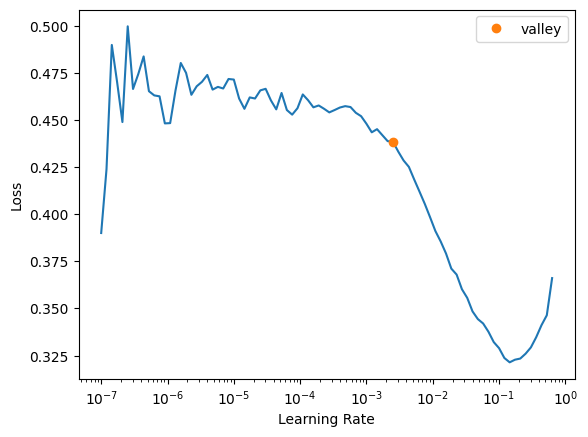

In [28]:
lr_max = learn.lr_find().valley

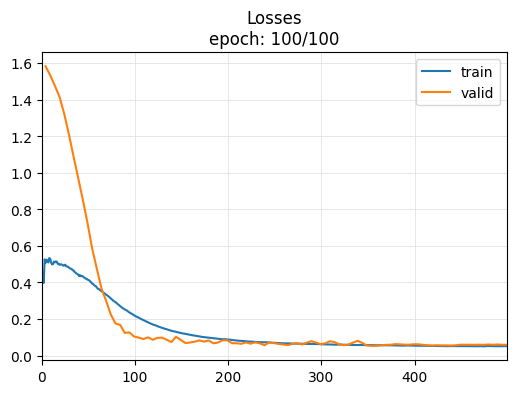

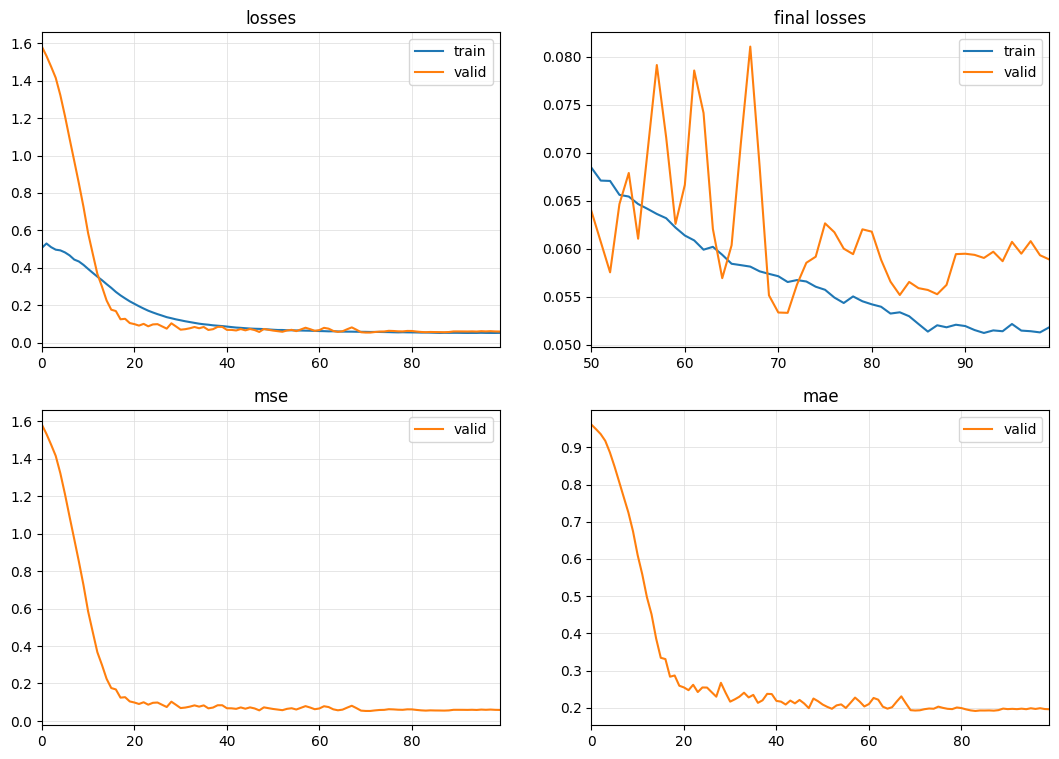

In [29]:
modelPath = Path('data/airline')
learn = TSForecaster(X, y, splits=splits, batch_size=16, path=modelPath, pipelines=[preproc_pipe, scale_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=[ShowGraph()])

n_epochs = 100
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST.pt')

In [1]:
import pandas as pd
from tsai.basics import *
from pathlib import Path
from src.utils import DateTimeConverter

df_raw = pd.read_csv('data/airline/airline.csv')
modelPath = Path('data/airline/patchTST.pt')

lookbackWindow = 16
forecastWindow = 6
datetime_col = "Month"
freq = 'MS'
input_field = ['passengers_in_thousands']
output_field = ['passengers_in_thousands']

In [18]:
learn = load_learner(modelPath)
df = df_raw.copy()
df = learn.transform(df)

old_X, _ = prepare_forecasting_data(df, fcst_history=lookbackWindow, fcst_horizon=forecastWindow,
                                x_vars=input_field, y_vars=output_field)
old_preds, *_ = learn.get_X_preds(old_X)
old_preds = torch.cat((old_preds[:-1, :,0], old_preds[-1,:,:].T), dim=0)

lastlookbackWindow, _ = prepare_forecasting_data(df[-lookbackWindow:], fcst_history=lookbackWindow, fcst_horizon=0,
                                                x_vars=input_field, y_vars=output_field)

new_pred, *_ = learn.get_X_preds(lastlookbackWindow)
new_pred = torch.swapaxes(new_pred.squeeze(0), 0, 1)
preds = torch.concat((old_preds, new_pred))

dates = pd.date_range(start=df.loc[lookbackWindow, datetime_col],
                periods = len(df.loc[lookbackWindow:]) + forecastWindow,
                freq=freq)
preds_df = pd.DataFrame(dates, columns=['Month'])

preds_df.loc[:, output_field] = preds

learn.pipelines[1].inverse_transform(df)
learn.pipelines[1].inverse_transform(preds_df)

new_columns = [col + '_pred' if col in output_field else col for col in preds_df.columns]

preds_df = preds_df.rename(columns=dict(zip(df.columns, new_columns)))

In [21]:
merged_df = pd.merge(df, preds_df, on='Month', how='outer')

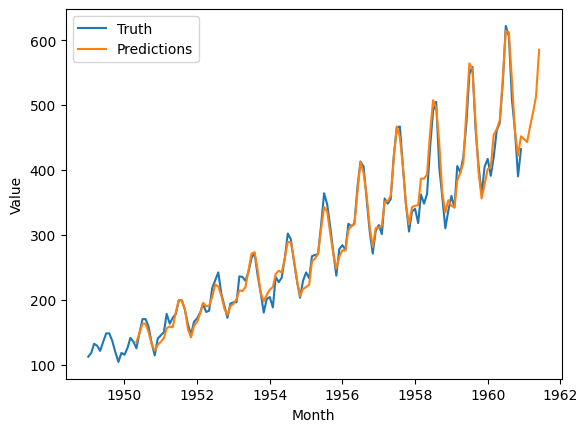

In [22]:
import matplotlib.pyplot as plt

plt.plot(merged_df['Month'], merged_df['passengers_in_thousands'], label = 'Truth')
plt.plot(merged_df['Month'], merged_df['passengers_in_thousands_pred'], label = 'Predictions')

plt.xlabel('Month')
plt.ylabel('Value')

plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt



In [89]:
dates = pd.date_range(start = df_raw['Month'].iloc[-1], periods = forecastWindow+1, freq = 'MS')
preds_df = pd.DataFrame(dates, columns=['Month'])
preds_df

,Month
0,1960-12-01
1,1961-01-01
2,1961-02-01
3,1961-03-01
4,1961-04-01
5,1961-05-01
6,1961-06-01


In [82]:
new_df = pd.DataFrame(index =dates)

In [84]:
df = pd.concat([df, pd.DataFrame(dates)])

In [23]:
lookbackWindow = 16
df =  df_raw[-lookbackWindow:].reset_index()

df = learn.transform(df)

df

Initial memory usage: 512.00 B  
Final memory usage  : 416.00 B   (-18.8%)


,Month,index,passengers_in_thousands
0,1959-09-01,128,3.494606
1,1959-10-01,129,2.714569
2,1959-11-01,130,2.087754
3,1959-12-01,131,2.686711
4,1960-01-01,132,2.853861
5,1960-02-01,133,2.491702
6,1960-03-01,134,2.881720
7,1960-04-01,135,3.466747
8,1960-05-01,136,3.619969
9,1960-06-01,137,4.497510


In [25]:
input_field = ['passengers_in_thousands']
new_X, _ = prepare_forecasting_data(df, fcst_history=lookbackWindow, fcst_horizon=0, x_vars=input_field, y_vars=None)

In [31]:
preds, *_ = learn.get_X_preds(new_X)

In [33]:
preds

tensor([[[3.2774, 3.2160, 3.5369, 3.8479, 4.1950, 5.1959]]])

In [31]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

modelPath = Path('data/airline/patchTST.pt')
learn = load_learner(modelPath)
y_test_preds, *_ = learn.get_X_preds(X[splits[1]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[1]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

y_test_preds.shape: (24, 1, 6)


,mse,mae
test,0.067787,0.210975


In [9]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pathlib import Path
from src.utils import DateTimeConverter
import pandas as pd

dataPath = Path('data/airline/airline.csv')
modelPath = Path('data/airline/patchTST.pt')

df_raw = pd.read_csv(dataPath)
learn = load_learner(modelPath)

df = df_raw.copy()

for pipe in learn.pipelines:
    df = pipe.transform(df)

Initial memory usage: 2.38 KB   
Final memory usage  : 1.53 KB    (-35.5%)


In [36]:
learn.get_preds(dl=learn.dls.train)

(None, None)

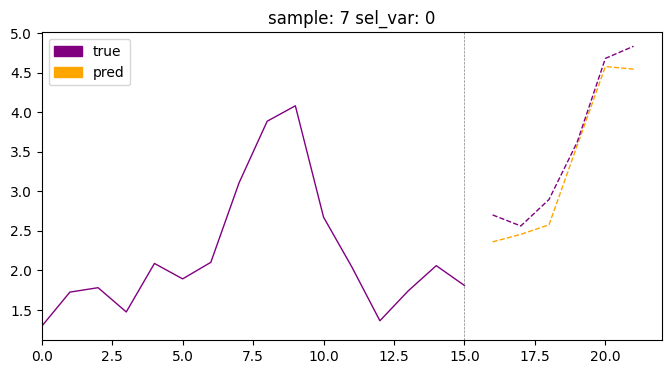

In [45]:
X_test = X[splits[1]]
y_test = y[splits[1]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)

# Using Class


In [3]:
from src.forecast_strategy import DeepLearningStrategy
from src.utils import DateTimeConverter

import pandas as pd
from pathlib import Path

data = pd.read_csv('data/airline/airline.csv')

input_field = ['passengers_in_thousands']
output_field = ['passengers_in_thousands']

datetime_col = 'Month'
freq = 'MS'

nEpochs = 50
lookbackWindow = 16
forecastWindow = 6

patchTSTStrategy = DeepLearningStrategy(model_path = Path('data/airline/patchTST.pt'),
                                        arch="PatchTST", 
                                        arch_config_path = 'src/models/PatchTST/n3_h4_md16_fd128_pl2_s2.json')

patchTSTStrategy.load_data(data)

[Pipeline]  (step 1 of 5) Processing datetime_converter, total=   0.0s
Initial memory usage: 1.06 MB   
Final memory usage  : 612.55 KB  (-43.7%)
[Pipeline] .......... (step 2 of 5) Processing shrinker, total=   0.0s
[Pipeline] ... (step 3 of 5) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 4 of 5) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 5 of 5) Processing fill_missing, total=   0.0s


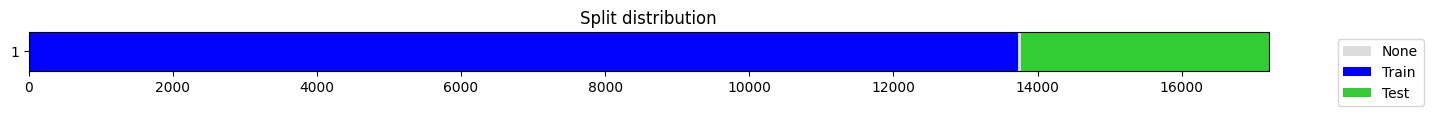

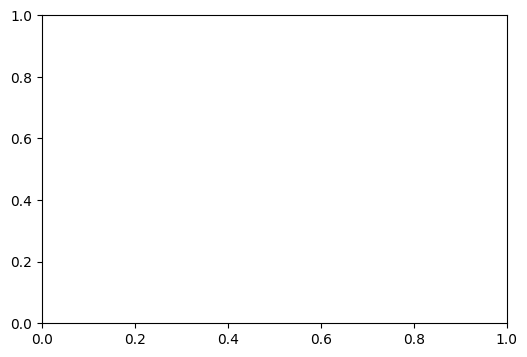

KeyboardInterrupt: 

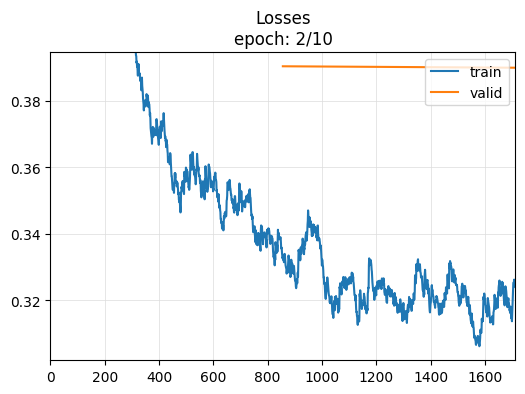

In [2]:
patchTSTStrategy.train(input_field=input_field, output_field=output_field,
                        lookbackWindow=lookbackWindow, forecastWindow=forecastWindow,
                        datetime_col=datetime_col, freq=freq, nEpochs=nEpochs)

In [4]:
merged_df = patchTSTStrategy.forecast(input_field=input_field, output_field=output_field,
                          forecastWindow=forecastWindow, lookbackWindow=lookbackWindow,
                          datetime_col=datetime_col, freq=freq)

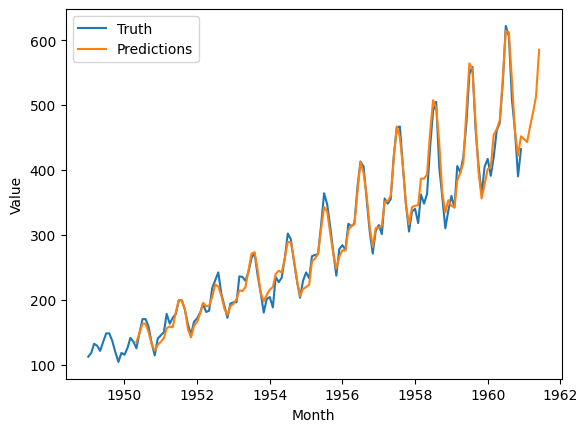

In [5]:
import matplotlib.pyplot as plt

plt.plot(merged_df['Month'], merged_df['passengers_in_thousands'], label = 'Truth')
plt.plot(merged_df['Month'], merged_df['passengers_in_thousands_pred'], label = 'Predictions')

plt.xlabel('Month')
plt.ylabel('Value')

plt.legend()
plt.show()